In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import feather
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity

# Load data

In [2]:
tags = pd.read_csv('./data/tags.csv')
books = feather.read_dataframe('./feather/books')
book_tags = pd.read_csv('./data/book_tags.csv')
(tags.shape, books.shape, book_tags.shape)

((34252, 2), (10000, 4), (999912, 3))

In [3]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [4]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [5]:
len(book_tags.goodreads_book_id.unique())

10000

# Filter out tags

34k tags, or keywords might be a little bit unnecessary, considering that there are some meaningless ones, like --1- or --10-, which will probably have very low count. Let's find out how many count each tag has and which ones are the most popular.

In [8]:
# Remove 2 tag with negative count
counts = book_tags.groupby('tag_id').sum()[['count']].sort_values(by='count', ascending=False)[:-2]
counts['tag_name'] = tags.set_index('tag_id', drop=True).loc[counts.index]
counts.head(15)

,count,tag_name
tag_id,,
30574,140718761,to-read
8717,7507958,currently-reading
11557,4503173,favorites
11743,3688819,fiction
11305,3548157,fantasy
33114,1848306,young-adult
7457,1756920,classics
5207,1317235,books-i-own
26138,1231926,romance


Unfortunately, some of the most popular tags are not book attributes that we can utilize in our similarity function, for example 'to-read' and 'favorites' are not inherent qualties of a book. For this problem, the only solution available right now is to clean them manually. I'll go through the top 300 tags and remove tags that are intuitively not innate characteristics of a book.

In [9]:
top_tags = counts[:300]
top_tags.shape

(300, 2)

In [11]:
tags_to_skip = [30574, 8717, 11557, 5207, 22743, 17213, 4949, 18045, 11590, 
                22753, 9221, 30521, 20774, 15169, 25151, 32586, 20849, 25152, 25150, 25149, 
                24960, 11497, 2104, 22689, 25148, 11505, 1128, 9638, 9477, 240, 25153,
                24997, 25147, 24999, 24996, 5051, 5481, 14064, 1078, 27535, 24995, 236, 
                25822, 31505, 29316, 25765, 25146, 9484, 11978, 11550, 20824, 30672, 22352,
                26256, 783, 11491, 831, 20731, 251, 24993, 751, 7478, 21815, 4959, 25506,
                25000, 4985, 30573, 22330, 17217, 5444, 32099, 14764, 18051, 722, 11503,
                21274, 5180, 20781, 20811]
print("Tags skipped:", len(tags_to_skip))
counts.loc[tags_to_skip].head(10)

Tags skipped: 80


,count,tag_name
tag_id,,
30574,140718761,to-read
8717,7507958,currently-reading
11557,4503173,favorites
5207,1317235,books-i-own
22743,1224279,owned
17213,506882,kindle
4949,446685,book-club
18045,429171,library
11590,423289,favourites


So, 80 out of the top 300 are tags that are either totally irrelevant or not relevant enough to be considered an attribute of a book. Somewhere between 50 and 300 keywords is a good number so we're happy with 220.

In [14]:
filtered_tags = top_tags.loc[~top_tags.index.isin(tags_to_skip)]
print("Tags kept:", len(filtered_tags))
filtered_tags.head(15)

Tags kept: 220


,count,tag_name
tag_id,,
11743,3688819,fiction
11305,3548157,fantasy
33114,1848306,young-adult
7457,1756920,classics
26138,1231926,romance
32989,898334,ya
20939,872282,mystery
21689,857901,non-fiction
14487,815421,historical-fiction


Looks much more natural now. There can still be improvement, such as removal of duplicates, but we'll put that for a later date for now. Now we will filter out the book_tags using the tags we have chosen.

In [30]:
tags_kept = filtered_tags.index
filtered_book_tags = book_tags[book_tags.tag_id.isin(tags_kept)]
# Remove invalid entry (count = -1 and duplicated)
filtered_book_tags = filtered_book_tags[filtered_book_tags['count']>0].drop(265128, axis=0)
filtered_book_tags.shape

(323209, 3)

In [31]:
# The number of books that has tags
len(filtered_book_tags.goodreads_book_id.unique())

10000

In [32]:
filtered_book_tags['normalized_count'] = filtered_book_tags['count'].apply(lambda x: math.log(1 + x, 2))
filtered_book_tags.head(15)

,goodreads_book_id,tag_id,count,normalized_count
1,1,11305,37174,15.182045
4,1,33114,12716,13.634471
5,1,11743,9954,13.281206
6,1,14017,7169,12.807757
9,1,32989,4364,12.091766
10,1,27199,3857,11.913637
12,1,18886,3374,11.720672
13,1,6953,2408,11.234219
16,1,1691,1742,10.767357
17,1,6857,1560,10.608255


The count is then normalized because the numbers intuitively make more sense and the distribution then will be smoother.

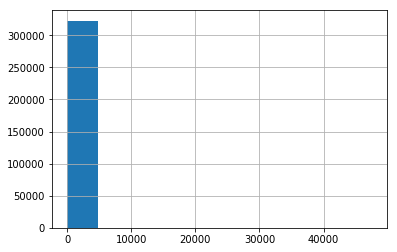

In [33]:
filtered_book_tags['count'].hist()

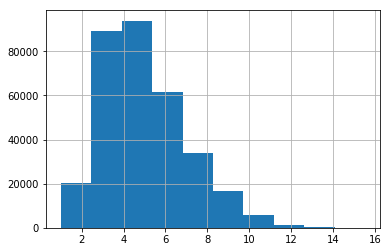

In [34]:
filtered_book_tags.normalized_count.hist()

# Adding author as a tag

The other important field in a similarity function (or content-based systems) is the author. But first in order to use the author we need to clean it first.

In [35]:
books.head(15).authors

0                                       Suzanne Collins
1                           J.K. Rowling, Mary GrandPré
2                                       Stephenie Meyer
3                                            Harper Lee
4                                   F. Scott Fitzgerald
5                                            John Green
6                                        J.R.R. Tolkien
7                                         J.D. Salinger
8                                             Dan Brown
9                                           Jane Austen
10                                      Khaled Hosseini
11                                        Veronica Roth
12              George Orwell, Erich Fromm, Celâl Üster
13                                        George Orwell
14    Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...
Name: authors, dtype: object

Too bad our author data is a string possible of contaning multiple authors. So we must separate them, add them to the tag list and make an index of author name to tag_id

In [36]:
max_book_tags = filtered_book_tags.groupby('goodreads_book_id').max()
max_book_tags.head()

,tag_id,count,normalized_count
goodreads_book_id,,,
1,33165,37174,15.182045
2,33165,3441,11.749031
3,33165,47478,15.535002
5,33165,39330,15.263379
6,33165,38378,15.228030


In [37]:
# Get the author list for each book
authors = books[['goodreads_book_id', 'authors']]
authors.loc[:, 'authors_list'] = books.authors.str.split(',').apply(lambda x: list(map(lambda s: s.replace(" ", ""), x)))
authors.head()

C:\Users\hle\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hle\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,goodreads_book_id,authors,authors_list
0,2767052,Suzanne Collins,[SuzanneCollins]
1,3,"J.K. Rowling, Mary GrandPré","[J.K.Rowling, MaryGrandPré]"
2,41865,Stephenie Meyer,[StephenieMeyer]
3,2657,Harper Lee,[HarperLee]
4,4671,F. Scott Fitzgerald,[F.ScottFitzgerald]


In [38]:
# Make the author_tags dataframe and add the author tags to the book_tags with the normalized_count equal
# to the highest normalized_count of that specific book
author_index = {}
start_tag_id = len(tags)
author_tags = pd.DataFrame({'tag_id': pd.Series().astype(int), 'tag_name': []})
author_book_tags = pd.DataFrame({
    'goodreads_book_id': pd.Series().astype(int),
    'tag_id': pd.Series().astype(int),
    'count': pd.Series().astype(int),
    'normalized_count': pd.Series()
})

for index, entry in authors.iterrows():
    for author in entry.authors_list:
        if author not in author_index:
            new_tag_id = start_tag_id + len(author_index)
            author_index[author] = new_tag_id
            author_tags.loc[len(author_index)] = [new_tag_id, author]
        tag_id = author_index[author]
        _, count, normalized_count = max_book_tags.loc[entry.goodreads_book_id]
        author_book_tags.loc[len(author_book_tags)] = [int(entry.goodreads_book_id), int(tag_id), int(count), normalized_count]

author_tags.shape

(5833, 2)

In [39]:
author_tags.head(10)

,tag_id,tag_name
1,34252,SuzanneCollins
2,34253,J.K.Rowling
3,34254,MaryGrandPré
4,34255,StephenieMeyer
5,34256,HarperLee
6,34257,F.ScottFitzgerald
7,34258,JohnGreen
8,34259,J.R.R.Tolkien
9,34260,J.D.Salinger
10,34261,DanBrown


In [40]:
final_book_tags = filtered_book_tags \
                            .append(author_book_tags, ignore_index=False) \
                            .astype({'goodreads_book_id': int, 'tag_id': int, 'count': int}) \
                            .reset_index(drop=True) \
                            .drop_duplicates()
final_book_tags.tail()

,goodreads_book_id,tag_id,count,normalized_count
336420,7130616,35779,1004,9.972980
336421,208324,38626,309,8.276124
336422,77431,36418,548,9.100662
336423,8565083,40083,847,9.727920
336424,8914,40084,776,9.601771


In [42]:
tag_matrix = final_book_tags.pivot(index='goodreads_book_id', columns='tag_id', values='normalized_count').fillna(0)
tag_matrix.shape

(10000, 6053)

In [43]:
tag_matrix.head()

tag_id,509,923,1416,1540,1542,1642,1659,1691,1746,1800,...,40075,40076,40077,40078,40079,40080,40081,40082,40083,40084
goodreads_book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.767357,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,7.820179,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,11.247334,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.953469,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.886459,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let's convert goodreads_book_id to our native book_id

In [44]:
book_id_idx = books[['goodreads_book_id', 'book_id']].set_index('goodreads_book_id')
tag_matrix['book_id'] = book_id_idx.loc[tag_matrix.index]
tag_matrix.set_index('book_id', inplace=True)
tag_matrix.head()

tag_id,509,923,1416,1540,1542,1642,1659,1691,1746,1800,...,40075,40076,40077,40078,40079,40080,40081,40082,40083,40084
book_id,,,,,,,,,,,,,,,,,,,,,
27,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.767357,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,7.820179,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,11.247334,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.953469,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10.886459,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's test a few book to see if we did it correctly

In [45]:
final_tags = tags.append(author_tags).set_index('tag_id')
final_tags.tail()

,tag_name
tag_id,
40080,BenOkri
40081,MilesCameron
40082,IanMortimer
40083,PeggyOrenstein
40084,JohnKeegan


In [46]:
# Pick a Harry Potter book
books[books.book_id==2].title

1    Harry Potter and the Sorcerer's Stone (Harry P...
Name: title, dtype: object

In [47]:
# Harry Potter and the Sorcerer's Stone
hp1 = tag_matrix.loc[2].sort_values(ascending=False)
hp1 = hp1[hp1>0]
pd.DataFrame({'tag': final_tags.loc[hp1.index].tag_name, 'strength': hp1}).head(15)

,tag,strength
tag_id,,
34254,MaryGrandPré,15.535002
34253,J.K.Rowling,15.535002
11305,fantasy,15.535002
33114,young-adult,13.871231
11743,fiction,13.692616
14017,harry-potter,13.063395
32989,ya,12.365502
27199,series,12.327833
18886,magic,12.071127


Looking good! Now we will turn that matrix into a space vector to be able to use the cosine similarity as our similarity function

In [48]:
final_tag_matrix = pd.DataFrame(
    data = preprocessing.normalize(tag_matrix.values, norm='l2'),
    index = tag_matrix.index,
    columns = tag_matrix.columns
)
final_tag_matrix.head()

tag_id,509,923,1416,1540,1542,1642,1659,1691,1746,1800,...,40075,40076,40077,40078,40079,40080,40081,40082,40083,40084
book_id,,,,,,,,,,,,,,,,,,,,,
27,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.147310,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.124504,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.147864,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.143757,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.148370,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Harry Potter 1
hp1 = final_tag_matrix.loc[2].sort_values(ascending=False)
hp1 = hp1[hp1>0]
pd.DataFrame({'tag': final_tags.loc[hp1.index].tag_name, 'strength': hp1}).head(15)

,tag,strength
tag_id,,
34254,MaryGrandPré,0.204232
34253,J.K.Rowling,0.204232
11305,fantasy,0.204232
33114,young-adult,0.182359
11743,fiction,0.180011
14017,harry-potter,0.171738
32989,ya,0.162564
27199,series,0.162068
18886,magic,0.158694


We are set! Now it's time to create to similarity dataframe

In [50]:
cosine_sim = pd.DataFrame(
    data = cosine_similarity(final_tag_matrix, final_tag_matrix),
    index = final_tag_matrix.index,
    columns = final_tag_matrix.index
)
cosine_sim.head()

book_id,27,21,2,18,24,3275,3753,54,337,374,...,5111,5296,8713,7443,6428,7523,4594,9569,9580,8892
book_id,,,,,,,,,,,,,,,,,,,,,
27,1.000000,0.793039,0.967074,0.935959,0.932615,0.773161,0.826935,0.443948,0.383335,0.145548,...,0.191713,0.276920,0.220817,0.665664,0.613295,0.679846,0.121582,0.397349,0.165843,0.226996
21,0.793039,1.000000,0.781584,0.756703,0.802735,0.606846,0.642205,0.371239,0.290013,0.128655,...,0.132455,0.262205,0.181788,0.483300,0.445195,0.511246,0.116972,0.341285,0.114551,0.164359
2,0.967074,0.781584,1.000000,0.954254,0.951350,0.779767,0.838700,0.463165,0.400693,0.146866,...,0.159402,0.254301,0.199595,0.665316,0.612849,0.679313,0.122899,0.366076,0.148561,0.172504
18,0.935959,0.756703,0.954254,1.000000,0.919456,0.750132,0.813695,0.444069,0.384745,0.159378,...,0.153586,0.262145,0.192761,0.646410,0.607130,0.660081,0.135276,0.368633,0.142581,0.166399
24,0.932615,0.802735,0.951350,0.919456,1.000000,0.741594,0.802514,0.488001,0.413613,0.164158,...,0.157931,0.270466,0.198930,0.636164,0.583238,0.648697,0.139250,0.398710,0.146673,0.171259


Now we got our similarity function

In [51]:
book_title_idx = books.set_index('book_id')['title']
def check_similarity(book_id_1, book_id_2):
    print("Book 1:", book_title_idx.loc[book_id_1])
    print("Book 2:", book_title_idx.loc[book_id_2])
    print("Similarity:", cosine_sim.loc[book_id_1][book_id_2])
check_similarity(27, 21)

Book 1: Harry Potter and the Half-Blood Prince (Harry Potter, #6)
Book 2: Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Similarity: 0.793039082631223


We can check top 10 books that are similar to a book

In [52]:
def top_10(book_id):
    print("Top 10 similar book to", book_title_idx.loc[book_id])
    results = cosine_sim.loc[book_id].sort_values(ascending=False).index
    print("Score\tTitle")
    for i in range(0, 11):
        id = results[i]
        print("%.2f\t%s" % (cosine_sim.loc[book_id][id], book_title_idx.loc[id]))
        
# Books that are most similar to Harry Potter and the Half-Blood Prince
top_10(27)

Top 10 similar book to Harry Potter and the Half-Blood Prince (Harry Potter, #6)
Score	Title
1.00	Harry Potter and the Half-Blood Prince (Harry Potter, #6)
0.98	Harry Potter and the Deathly Hallows (Harry Potter, #7)
0.97	Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
0.96	Harry Potter and the Chamber of Secrets (Harry Potter, #2)
0.94	Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
0.93	Harry Potter and the Goblet of Fire (Harry Potter, #4)
0.87	Harry Potter Boxset (Harry Potter, #1-7)
0.83	The Tales of Beedle the Bard
0.83	Harry Potter Collection (Harry Potter, #1-6)
0.82	The Harry Potter Collection 1-4 (Harry Potter, #1-4)
0.80	Inkheart (Inkworld, #1)


The result is what we expected
- The most similar book is of course itself, so we can always assume it will be at the top of the list
- Most of the books in the list come from the Harry Potter franchise, which makes sense as their contents are similar

Finally, we will save the tag_matrix (book profiles) to use them later on. Since feather doesn't allow non-default index and non-string column we'll set the column to tag name instead of tag id and reset the index. The next time we use it we can set the index back to book_id. The similarity dataframe can be easily recreated from the profiles so we don't need to save it

In [53]:
book_profiles = final_tag_matrix.copy()
book_profiles.columns = final_tags.loc[book_profiles.columns].values.flatten()
book_profiles.reset_index(inplace=True)
book_profiles.head()

,book_id,19th-century,20th-century,abandoned,action,action-adventure,adult,adult-fiction,adventure,africa,...,PeterMatthiessen,StevePieczenik,TerriBlackstock,JohnRawls,OscarHijuelos,BenOkri,MilesCameron,IanMortimer,PeggyOrenstein,JohnKeegan
0,27,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.147310,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0.0,0.0,0.0,0.124504,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.147864,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.143757,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.148370,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
book_profiles.to_feather('./feather/book_profiles')